In [1]:
import os
import json
import cdsapi
import netCDF4
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

   Define Processing Functions

In [2]:
def closest_point(x, y, xArr, yArr):
    array = np.asarray(xArr)
    idx = (np.abs(array - x)).argmin()
    array = np.asarray(yArr)
    idy = (np.abs(array - y)).argmin()
    return idx, idy
def double_arr(arr):
    data = []
    for i in arr:
        data.append(i)
        data.append(i)
    return data

Open connection to CDS API and import coordinates of sample stations

In [3]:
c = cdsapi.Client()
with open('coords.json') as json_file:
    coords = json.load(json_file)
downloaded = True

Download the data from the CDS API

In [4]:
if not downloaded:
    c.retrieve(
        "reanalysis-era5-single-levels-monthly-means",
        {
            'product_type': "monthly_averaged_reanalysis_by_hour_of_day",
            'format': "netcdf",
            'variable': "mean_surface_downward_short_wave_radiation_flux",
            'area': [49,2,44,14],
            'year': ["2017","2018","2019","2020"],
            'month': ["01","02","03","04","05","06","07","08","09","10","11","12"],
            'time': ["09:00","10:00","11:00","12:00"],
        },
        "monthly-morning.nc")

In [5]:
if not downloaded:
    c.retrieve(
        "reanalysis-era5-single-levels",
        {
            'product_type': "reanalysis",
            'format': "netcdf",
            'variable': "mean_surface_downward_short_wave_radiation_flux",
            'area': [49,2,44,14],
            'year': ["2017","2018","2019","2020"],
            'month': ["01","02","03","04","05","06","07","08","09","10","11","12"],
            'day': ["01","02","03","04","05","06","07","08","09","10","11","12","13","14","15","16","17","18","19",
                    "20","21","22","23","24","25","26","27","28","29","30","31"],
            'time': ["09:00","10:00","11:00","12:00"],
        },
        "daily-morning.nc")

Parse the files and average the morning values (using the last station location in the list of coords)

In [11]:
coords[-1]

{'name': 'SHL2', 'lat': 46.4527, 'lng': 6.58872}

In [6]:
nc = netCDF4.Dataset("monthly-morning.nc",mode='r',format='NETCDF4_CLASSIC')
lon = nc.variables["longitude"][:]
lat = nc.variables["latitude"][:]
idx, idy = closest_point(coords[-1]["lng"], coords[-1]["lat"], lon, lat)
time = np.array(nc.variables["time"][:]).astype(np.float)
monthly_date = []
monthly_value = []
for i in range(48):
    monthly_date.append(datetime(1900,1,1, 0,0) + timedelta(hours=time[i * 4]-9))
    monthly_date.append(datetime(1900,1,1,0,0) + timedelta(hours=time[(i * 4)]-9) + relativedelta(months=+1) + relativedelta(days=-1))
    monthly_value.append(np.mean(np.array(nc.variables["msdwswrf"][(i*4):((i*4)+4),idy,idx])))
    monthly_value.append(np.mean(np.array(nc.variables["msdwswrf"][(i*4):((i*4)+4),idy,idx])))
nc.close()

In [7]:
nc = netCDF4.Dataset("daily-morning.nc",mode='r',format='NETCDF4_CLASSIC')
lon = nc.variables["longitude"][:]
lat = nc.variables["latitude"][:]
idx, idy = closest_point(coords[-1]["lng"], coords[-1]["lat"], lon, lat)
time = np.array(nc.variables["time"][:]).astype(np.float)
daily_date = []
daily_value = []
for i in range(1461):
    daily_date.append(datetime(1900,1,1, 0,0) + timedelta(hours=time[i * 4]-9))
    daily_value.append(np.mean(np.array(nc.variables["msdwswrf"][(i*4):((i*4)+4),idy,idx])))
nc.close()

In [8]:
soomets = [397,397,634,634,979,979,1179,1179,1217,1217,1336,1336,1402,1402,
           1282,1282,1079,1079,730,730,447,447,323,323] * 4

Plot the results

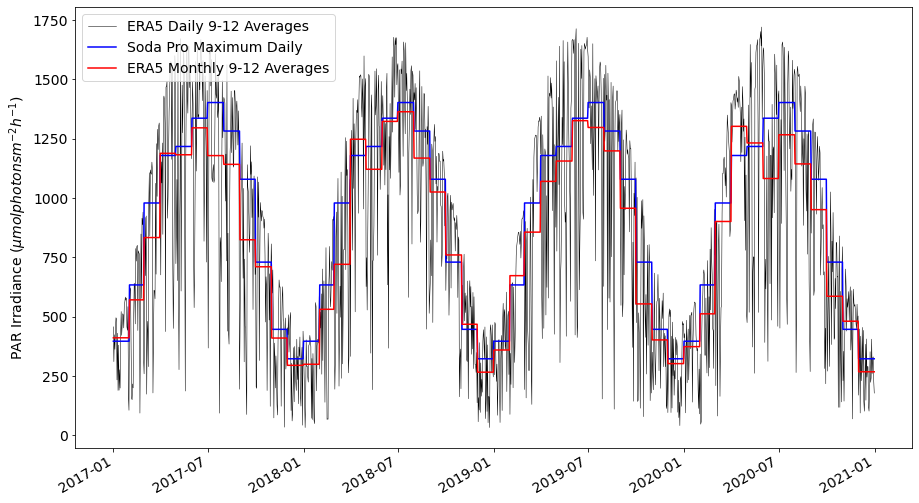

In [23]:
fig, ax = plt.subplots()
ax.plot(daily_date, np.array(daily_value) * 4.6 * 0.436, "-k",linewidth=0.5, label="ERA5 Daily 9-12 Averages")
ax.plot(monthly_date, soomets, "-b", label="Soda Pro Maximum Daily")
ax.plot(monthly_date, np.array(monthly_value) * 4.6 * 0.436, "-r",label="ERA5 Monthly 9-12 Averages")
plt.ylabel("PAR Irradiance ($μmol photons m^{-2}h^{-1}$)")
plt.legend()
plt.rcParams.update({'font.size': 18})
fig.autofmt_xdate()
fig.set_size_inches(15, 9)
plt.savefig('PAR_comparison.pdf')